In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, FunctionTransformer, RobustScaler, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

from models.prepareData import getData, convertData, calcMinimumMaximum, calcPercentiles
from models.models import linearRegressionModel, PolynomialFeatures, lassoRegressionModel, ridgeRegressionModel
from models.models import RANSACRegressionModel, PolynomialRegressionModel, polynomialRegression

In [3]:
# data = getData('Bán căn hộ chung cư', 'Nguyễn Hữu Thọ', 'Phước Kiển', 'Nhà Bè')
# data = getData('Bán căn hộ chung cư', 'Nguyễn Hữu Cảnh', '22', 'Bình Thạnh')
# data = getData('Bán căn hộ chung cư', 'Bến Vân Đồn', '1', '4')
# data = getData('Bán đất', 'Trần Văn Giàu', 'Lê Minh Xuân', 'Bình Chánh')
# data = getData('Bán đất', 'Vườn Lài', 'An Phú Đông', '12')
# data = getData('Bán đất', 'Nhuận Đức', 'Củ Chi')
# data = getData('Bán nhà riêng', 'Quốc Lộ 13', 'Hiệp Bình Phước', 'Thủ Đức')
# data = getData('Bán nhà riêng', 'Phạm Văn Chiêu', '9', 'Gò Vấp')
# data = getData('Bán nhà riêng', 'Nguyễn Văn Quá', 'Đông Hưng Thuận', '12')
# data = getData('Bán nhà riêng', 'Quốc Lộ 13', 'Hiệp Bình Phước', 'Thủ Đức')
# data = getData('Bán nhà riêng', 'Thành Thái', '14', '10')
# data = getData('Bán nhà riêng', 'Lạc Long Quân', '3', '11')
# data = getData('Bán nhà riêng', '3/2', '14', '10')
# data = getData('Bán đất', 'Nguyễn Thị Rành', 'Nhuận Đức', 'Củ Chi')
# data = getData('Bán đất', 'Tôn Đản', '10', '4')
# data = getData('Bán căn hộ chung cư', '9A', 'Bình Hưng', 'Bình Chánh')
# data = getData('Bán đất', 'Bà Thiên', 'Nhuận Đức', 'Củ Chi')
data = getData('Bán đất', 'Nguyễn Thị Rành', 'Nhuận Đức', 'Củ Chi')
# data = getData('Bán nhà riêng', 'Số 8', 'Linh Xuân', 'Thủ Đức')
# data = getData('Bán đất', 'Bình Mỹ', 'Bình Mỹ', 'Củ Chi')
# data = getData('Bán đất', 'Nguyễn Văn Tạo', 'Long Thới', 'Nhà Bè')
# data = getData('Bán nhà riêng', 'Lê Đình Cẩn', 'Tân Tạo', 'Bình Tân')
# data = getData('Bán đất', 'Hoàng Phan Thái', 'Bình Chánh', 'Bình Chánh')
# data = getData('Bán đất', 'Lê Văn Lương', 'Phước Kiển', 'Nhà Bè')

In [4]:
# post_type = data['post_type'].iloc[0]
# street = data['street'].iloc[0]
# ward = data['ward'].iloc[0]
# district = data['district'].iloc[0]

In [5]:
data[(data['area'] > 90) & (data['area'] < 150)]

,post_type,area,price,street,ward,district,posted_date
21,Bán đất,125.0,1.22,Nguyễn Thị Rành,Nhuận Đức,Củ Chi,2021-02-22
67,Bán đất,125.0,1.65,Nguyễn Thị Rành,Nhuận Đức,Củ Chi,2021-04-07
126,Bán đất,125.0,1.30,Nguyễn Thị Rành,Nhuận Đức,Củ Chi,2021-05-17


In [6]:
print("Data length: ", len(data))

Data length:  207


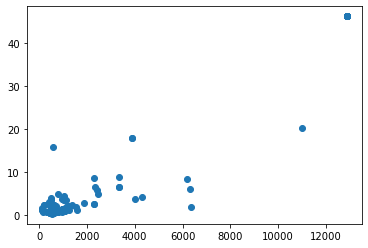

In [7]:
plt.scatter(data['area'], data['price'])
plt.show()

## Feature Engineering

### Clean data by observing dataset:

In [8]:
data = data[~(data['area'] < 10)]
data = data[~(data['price'] > 200)]

In [9]:
area_mean = np.mean(data['area'])
area_std = np.std(data['area'])

price_mean = np.mean(data['price'])
price_std = np.std(data['price'])

data = data[~( (data['area'] < area_mean) & (data['price'] > price_mean+1.5) )]
data = data[~( (data['area'] > area_mean) & (data['price'] < price_mean+1.5) )]

In [10]:
# print("Area mean: ", area_mean)
# print("Price mean: ", price_mean)

In [11]:
print("Data length: ", len(data))

Data length:  197


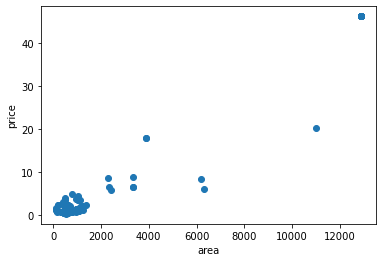

In [12]:
plt.scatter(data['area'], data['price'])
plt.xlabel('area')
plt.ylabel('price')
plt.show()

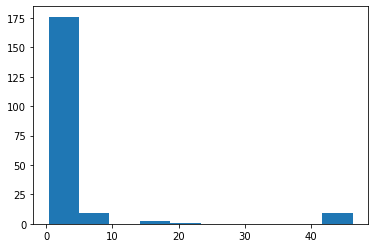

In [13]:
plt.hist(data['price'])
plt.show()

### Feature Scaling (both area & price)

In [14]:
# transform data into log1p
data['area'] = (data['area']).transform(np.log1p)
data['price'] = (data['price']).transform(np.log1p)

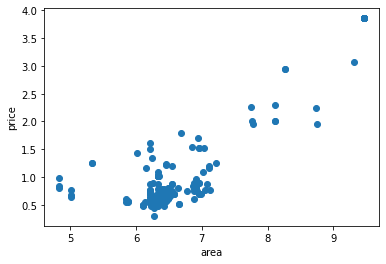

In [15]:
plt.scatter(data['area'], data['price'])
plt.xlabel('area')
plt.ylabel('price')
plt.show()

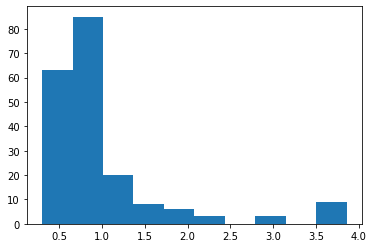

In [16]:
plt.hist(data['price'])
plt.show()

### Calculate mean of duplicated data

In [17]:
# Instead of drop duplicates try calc and use its mean value:
data = data.groupby(['area'], as_index=False).mean()

# sort data by area:
data = data.sort_values(by=['area'])

In [18]:
print("Data length: ", len(data))

Data length:  88


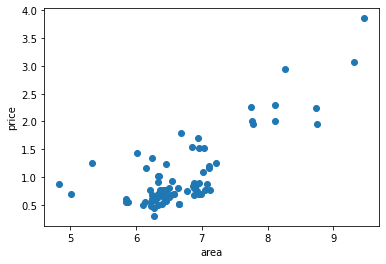

In [19]:
plt.scatter(data['area'], data['price'])
plt.xlabel('area')
plt.ylabel('price')
plt.show()

## RANSAC Algorithm in Detecting Outliers
- This method is not a good choice if the dataset not follow linear trends
- Beside, using a base estimator same with the current model will make this prediction in spoiled data => I assume that it is not a good practice

In [20]:
# test_area, test_price = convertData(data)

# # find degree by polynomial regression:
# run_model, model_name, found_degree, rmse = polynomialRegression(test_area, test_price)

# ransac_model = linear_model.RANSACRegressor(base_estimator=PolynomialRegressionModel(degree=found_degree), random_state=0)
# ransac_model.fit(test_area, test_price)

# inlier_mask = ransac_model.inlier_mask_
# outlier_mask = np.logical_not(inlier_mask)

In [21]:
# plt.scatter(data['area'], data['price'], color='blue')
# plt.scatter(test_area[outlier_mask], test_price[outlier_mask], color='red')
# plt.plot(test_area, ransac_model.predict(test_area))
# # run_model.predict(PolynomialFeatures(degree=found_degree).fit_transform(test_area)
# plt.show()

# outlier_indexes = np.where(outlier_mask==True)
# outlier_values = data.iloc[outlier_indexes]
# data = data.drop(outlier_values.index)

### Use IQR method to remove outliers

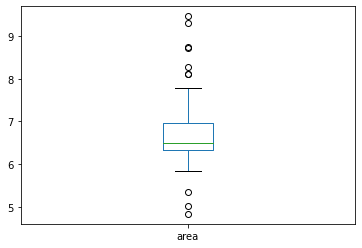

In [22]:
data['area'].plot(kind='box')
plt.show()

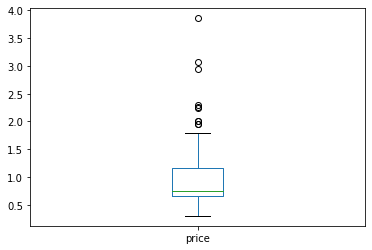

In [23]:
data['price'].plot(kind='box')
plt.show()

In [24]:
# Apply IQR method on area data:
area_minimum, area_maximum = calcMinimumMaximum(data['area'])
area_inliers = data[(data['area'] > area_minimum) & (data['area'] < area_maximum)]
area_outliers = data[(data['area'] < area_minimum) | (data['area'] > area_maximum)]
data = area_inliers
data

,area,price
3,5.843255,0.543486
4,5.843544,0.598837
5,5.874931,0.550970
6,6.013715,1.435085
7,6.111467,0.496188
...,...,...
76,7.123673,0.765468
77,7.210818,1.247032
78,7.741099,2.261763
79,7.755767,2.014903


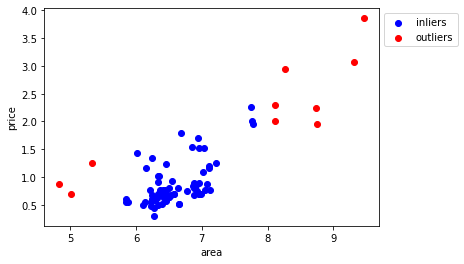

In [25]:
plt.scatter(area_inliers['area'], area_inliers['price'], color='blue', label='inliers')
plt.scatter(area_outliers['area'], area_outliers['price'], color='red', label='outliers')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.xlabel('area')
plt.ylabel('price')
plt.show()

In [26]:
print("Length = ", len(data))
max_value = data['area'].iloc[len(data)-1]
min_value = data['area'].iloc[0]

print("Max: ", max_value)
print("Min: ", min_value)

frame_value = (max_value - min_value) / 5
print("frame_value = ", frame_value)

frames_data = [ data[(data['area'] >= i*frame_value+min_value) & (data['area'] <= (i+1)*frame_value+min_value)].copy() for i in range(0, 5)]
frames_data[-1] = frames_data[-1].append(data[data['area'] > 5*frame_value+min_value])

Length =  78
Max:  7.783640596221253
Min:  5.843254519942795
frame_value =  0.3880772152556915


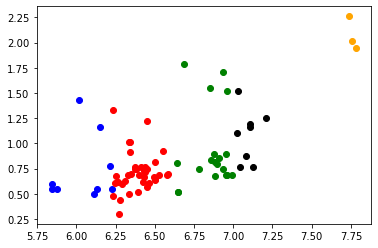

In [27]:
colors = ['blue', 'red', 'green', 'black', 'orange']
color_count = 0
for x in frames_data:
    plt.scatter(x['area'], x['price'], color=colors[color_count])
    color_count = color_count + 1
plt.show()

In [28]:
outliers = []
for i in range(len(frames_data)):
    price_minimum, price_maximum = calcPercentiles(frames_data[i]['price'])
#     price_minimum, price_maximum = calcMinimumMaximum(frames_data[i]['price'])
    print(price_minimum, " ", price_maximum)
    frames_inliers = frames_data[i].where((frames_data[i]['price'] > price_minimum) & (frames_data[i]['price'] < price_maximum))
    frames_outliers = frames_data[i].where((frames_data[i]['price'] <= price_minimum) | (frames_data[i]['price'] >= price_maximum))
    print(frames_data[i])
    frames_data[i] = frames_inliers.dropna()
    outliers.append(frames_outliers.dropna())
    
data = pd.concat(frames_data, ignore_index=True)
outliers_data = pd.concat(outliers, ignore_index=True)

0.5151073643494797   1.326311039095866
        area     price
3   5.843255  0.543486
4   5.843544  0.598837
5   5.874931  0.550970
6   6.013715  1.435085
7   6.111467  0.496188
8   6.133398  0.548121
9   6.148468  1.163151
10  6.216606  0.775294
11  6.226537  0.547226
0.4722126239240702   1.0363784108909844
        area     price
12  6.232448  0.475986
13  6.236370  1.335001
14  6.246107  0.609766
15  6.249975  0.678034
16  6.265301  0.620949
17  6.274762  0.300105
18  6.276643  0.438255
19  6.291569  0.593327
20  6.311735  0.625938
21  6.329721  0.686817
22  6.333280  0.499992
23  6.336826  1.015231
24  6.340359  0.912326
25  6.343880  1.015231
26  6.347389  0.694273
27  6.371612  0.765468
28  6.376727  0.741937
29  6.380123  0.741937
30  6.381816  0.741937
31  6.391917  0.518794
32  6.398595  0.684806
33  6.415097  0.765468
34  6.423247  0.620576
35  6.428105  0.724492
36  6.431331  0.666271
37  6.434547  0.765468
38  6.439350  0.712950
39  6.447306  0.741654
40  6.450470  0.567584
4

In [29]:
# plt.scatter(data['area'][:len(data)//5], data['price'][:len(data)//5], color='blue')
# plt.scatter(data['area'][len(data)//5:len(data)*2//5], data['price'][len(data)//5:len(data)*2//5], color='red')
# plt.scatter(data['area'][len(data)*2//5:len(data)*3//5], data['price'][len(data)*2//5:len(data)*3//5], color='green')
# plt.scatter(data['area'][len(data)*3//5:len(data)*4//5], data['price'][len(data)*3//5:len(data)*4//5], color='black')
# plt.scatter(data['area'][len(data)*4//5:], data['price'][len(data)*4//5:], color='purple')
# plt.show()

In [30]:
# part_data = data['price'][:len(data)//5]
# price_minimum, price_maximum = calcMinimumMaximum(part_data)
# data_1 = data[:len(data)//5][(part_data > price_minimum) & (part_data < price_maximum)]

# part_data = data['price'][len(data)//5:len(data)*2//5]
# price_minimum, price_maximum = calcMinimumMaximum(part_data)
# data_2 = data[len(data)//5:len(data)*2//5][(part_data > price_minimum) & (part_data < price_maximum)]

# part_data = data['price'][len(data)*2//5:len(data)*3//5]
# price_minimum, price_maximum = calcMinimumMaximum(part_data)
# data_3 = data[len(data)*2//5:len(data)*3//5][(part_data > price_minimum) & (part_data < price_maximum)]

# part_data = data['price'][len(data)*3//5:len(data)*4//5]
# price_minimum, price_maximum = calcMinimumMaximum(part_data)
# data_4 = data[len(data)*3//5:len(data)*4//5][(part_data > price_minimum) & (part_data < price_maximum)]

# part_data = data['price'][len(data)*4//5:]
# price_minimum, price_maximum = calcMinimumMaximum(part_data)
# data_5 = data[len(data)*4//5:][(part_data > price_minimum) & (part_data < price_maximum)]

# data = pd.concat([data_1, data_2, data_3, data_4, data_5], ignore_index=True)

In [31]:
print("Data length: ", len(data))
print("Outliers data length: ", len(outliers_data))

Data length:  64
Outliers data length:  14


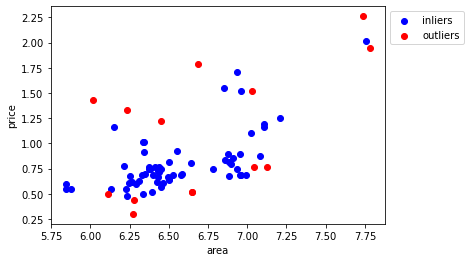

In [32]:
plt.scatter(data['area'], data['price'], color='blue', label='inliers')
plt.scatter(outliers_data['area'], outliers_data['price'], color='red', label='outliers')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.xlabel('area')
plt.ylabel('price')
plt.show()

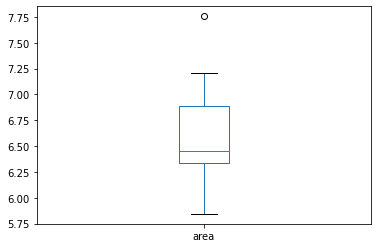

In [33]:
data['area'].plot(kind='box')
plt.show()

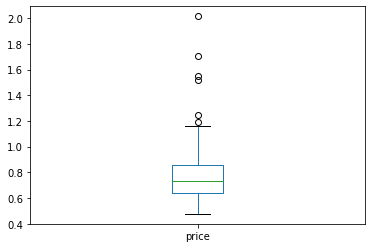

In [34]:
data['price'].plot(kind='box')
plt.show()

In [35]:
max_area = data['area'].max()
max_price = data['price'].max()

### Use Local Outlier Factor to remove _local outliers_

In [36]:
# from sklearn.neighbors import LocalOutlierFactor

# # convert dataframe into numpy array:
# X = data.to_numpy()
# n_neighbors = 8

In [37]:
# isNeighbors = LocalOutlierFactor(n_neighbors=n_neighbors, algorithm='brute', metric='euclidean', contamination=0.2).fit_predict(X)

# # locate outliers by index:
# outlier_indexes = np.where(isNeighbors == -1)
# outlier_values = data.iloc[outlier_indexes]

# # drop outliers:
# data = data.drop(outlier_values.index)

# print("\nOutliers detected by Local Outlier Factor with n_neighbors = ", n_neighbors)
# # plot outliers removed:
# plt.scatter(data['area'], data['price'], color='blue', label='inliers')
# plt.scatter(outlier_values['area'], outlier_values['price'], color='red', label='outliers')
# plt.legend(bbox_to_anchor=(1,1), loc="upper left")
# plt.tight_layout()
# plt.xlabel('area')
# plt.ylabel('price')
# plt.show()

### Split dataset
1. Train dataset: 70%
2. Validate dataset: 15%
3. Test dataset: 15%

In [38]:
# divide data into train and test:
train_data, test_data = train_test_split(data, test_size=0.25, random_state=4)
# test_data, validate_data = train_test_split(test_data, test_size=0.5, random_state=4)

In [39]:
# Sort data by area column:
train_data = train_data.sort_values(by=['area'])
test_data = test_data.sort_values(by=['area'])
# validate_data = validate_data.sort_values(by=['area'])

print("\nTrain data length: ", len(train_data))
print("Test data length: ", len(test_data))
# print("Validate data length: ", len(validate_data))


Train data length:  48
Test data length:  16


### Visualize features relationship

In [40]:
# # convert data into numpy
X, Y = convertData(data)
X_train, Y_train = convertData(train_data)
X_test, Y_test = convertData(test_data)
# X_validate, Y_validate = convertData(validate_data)

Text(0.5, 1.0, 'Y_test')

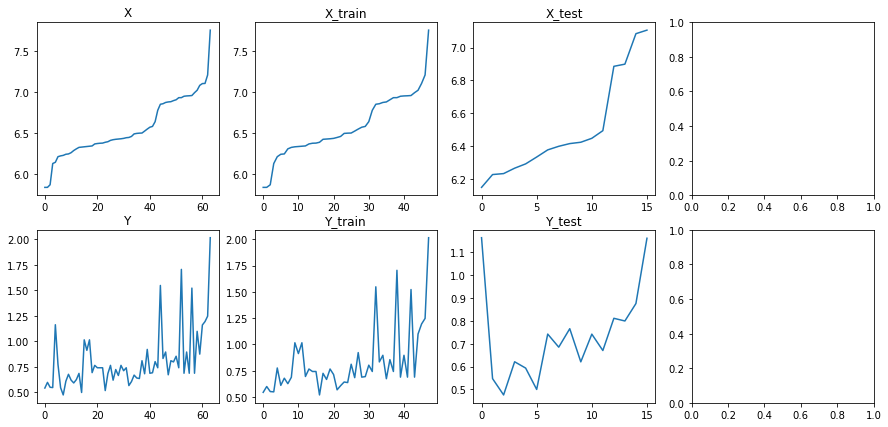

In [41]:
fig, ax = plt.subplots(2, 4, figsize=(15, 7))
ax[0][0].plot(X)
ax[0][0].set_title('X')
ax[0][1].plot(X_train)
ax[0][1].set_title('X_train')
ax[0][2].plot(X_test)
ax[0][2].set_title('X_test')
# ax[0][3].plot(X_validate)
# ax[0][3].set_title('X_validate')

ax[1][0].plot(Y)
ax[1][0].set_title('Y')
ax[1][1].plot(Y_train)
ax[1][1].set_title('Y_train')
ax[1][2].plot(Y_test)
ax[1][2].set_title('Y_test')
# ax[1][3].plot(Y_validate)
# ax[1][3].set_title('Y_validate')

## Evaluation Metrics

In [42]:
def calcRMSE(model, X, Y):
    return np.sqrt(mean_squared_error(Y, model.predict(X)))

def calcCV(model, X, Y, scoring):
    return np.mean(cross_val_score(model, X, Y, scoring=scoring, cv=6))

## Linear Regression Model

In [43]:
# find model by using linear regression:
linear_regression_model = linearRegressionModel(X_train, Y_train)

# find Y by using linear model predict:
Y_train_pred = linear_regression_model.predict(X_train)
# Y_validate_pred = linear_regression_model.predict(X_validate)
Y_test_pred = linear_regression_model.predict(X_test)

# Calculate RMSE on train and test data:
train_linear_rmse = np.sqrt(mean_squared_error(Y_train, Y_train_pred))
# validate_linear_rmse = np.sqrt(mean_squared_error(Y_validate, Y_validate_pred))
test_linear_rmse = np.sqrt(mean_squared_error(Y_test, Y_test_pred))


Linear Regression Model: 


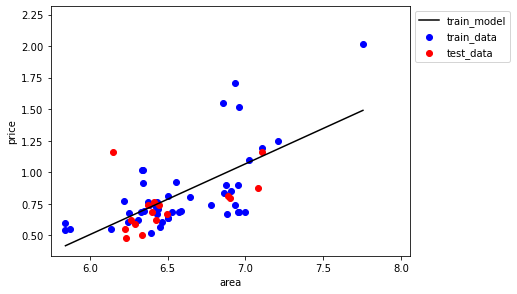

In [44]:
print("\nLinear Regression Model: ")
# Plot linear model:
plt.figure(figsize=(7, 4))
plt.scatter(X_train, Y_train, marker='o', color='blue', label='train_data')
plt.scatter(X_test, Y_test, marker='o', color='red', label='test_data')
# plt.scatter(X_validate, Y_validate, marker='o', color='green', label='validate_data')
plt.plot(X_train, Y_train_pred, color='black', label='train_model')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.tight_layout()
plt.xlabel('area')
plt.ylabel('price')
plt.xlim(right=max_area+0.3)
plt.ylim(top=max_price+0.3)
plt.show()

In [45]:
# Linear Model coefficient and intercept:
print("Linear model coefficient: {}".format(linear_regression_model.coef_))
print("Linear model intercept: {}".format(linear_regression_model.intercept_))

# linear_model rmse:
print("Linear model rmse on train data: {}".format(train_linear_rmse))
# print("Linear model rmse on validate data: {}".format(validate_linear_rmse))
print("Linear model rmse on test data: {}".format(test_linear_rmse))

# linear_model CV:
linear_cv_score = calcCV(linear_model.LinearRegression(fit_intercept=True, normalize=False), X_train, Y_train, 'r2')
print("Linear Regression CV score: ", linear_cv_score)
print("\n\n")

Linear model coefficient: [[0.56089457]]
Linear model intercept: [-2.85897329]
Linear model rmse on train data: 0.23073114313278428
Linear model rmse on test data: 0.19006973319386
Linear Regression CV score:  -1.5858672103925835





## Polynomial Regression Model

In [46]:
def polynomialTransform(dataset, degree):
    polynomial_features = PolynomialFeatures(degree=degree)
    dataset_poly = polynomial_features.fit_transform(dataset)
    return dataset_poly

Polynomial Regression with degree =  2
Polynomial model coefficient:
[[ 0.         -4.99879884  0.4170554 ]]
Polynomial model intercept: [15.61026754]

RMSE of poly model:  -0.22379155569307732
Polynomial Regression CV score:  -2.0151733925619246





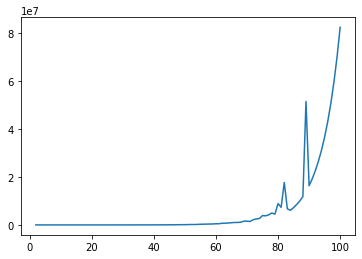

In [47]:
rmse_lst = []
degree_lst = [i for i in range(2, 101)]

# degree = 2
X_train_poly = polynomialTransform(X_train, 2)
# selected_poly_model = linearRegressionModel(X_train_poly, Y_train)
# min_poly_rmse = calcRMSE(selected_poly_model, X_train_poly, Y_train)
max_poly_rmse = calcCV(linear_model.LinearRegression(fit_intercept=True, normalize=False), X_train_poly, Y_train, 'neg_root_mean_squared_error')

# calc rmse on validate data:
# X_validate_poly = polynomialTransform(X_validate, 2)
# min_poly_rmse = calcRMSE(selected_poly_model, X_validate_poly, Y_validate)

rmse_lst.append(abs(max_poly_rmse))

# Choose model with specific degree:
selected_degree = 2
selected_X_train_poly = X_train_poly

min_degree = 3
max_degree = 100

for i in range(min_degree, max_degree+1):
    X_train_poly = polynomialTransform(X_train, i)
#     poly_model = linearRegressionModel(X_train_poly, Y_train)
#     rmse = calcRMSE(poly_model, X_train_poly, Y_train)
    rmse = calcCV(linear_model.LinearRegression(fit_intercept=True, normalize=False), X_train_poly, Y_train, 'neg_root_mean_squared_error')
    
    # calc rmse on validate data:
#     X_validate_poly = polynomialTransform(X_validate, i)
#     rmse = calcRMSE(poly_model, X_validate_poly, Y_validate)

    rmse_lst.append(abs(rmse))

    # Try to select the model with minimum rmse:
    if rmse > max_poly_rmse:
        max_poly_rmse = rmse
#         selected_poly_model = poly_model
        selected_X_train_poly = X_train_poly
        selected_degree = i
        
selected_poly_model = linearRegressionModel(selected_X_train_poly, Y_train)

# Predict Y:
Y_train_poly_pred = selected_poly_model.predict(selected_X_train_poly)

# calc RMSE:
# train_rmse = calcRMSE(selected_poly_model, selected_X_train_poly, Y_train)

print("Polynomial Regression with degree = ", selected_degree)
print("Polynomial model coefficient:")
print(selected_poly_model.coef_)
print("Polynomial model intercept: {}\n".format(selected_poly_model.intercept_))

# RMSE
# print("RMSE on train data: ", train_rmse)
print("RMSE of poly model: ", max_poly_rmse)

# poly CV
poly_cv_score = calcCV(linear_model.LinearRegression(fit_intercept=True, normalize=False), selected_X_train_poly, Y_train, 'r2')
print("Polynomial Regression CV score: ", poly_cv_score)
print("\n\n")

# print(rmse_lst)
plt.plot(np.array(degree_lst), np.array(rmse_lst))
plt.show()

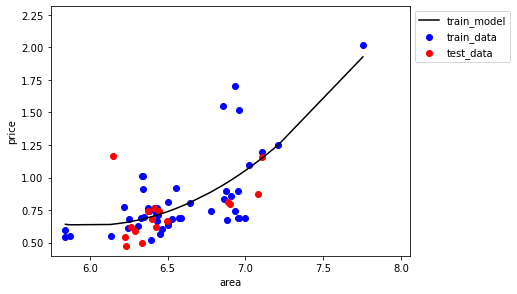

In [48]:
# Plot model:
plt.figure(figsize=(7, 4))
plt.scatter(X_train, Y_train, marker='o', color='blue', label='train_data')
plt.scatter(X_test, Y_test, marker='o', color='red', label='test_data')
# plt.scatter(X_validate, Y_validate, marker='o', color='green', label='validate_data')
plt.plot(X_train, Y_train_poly_pred, color='black', label='train_model')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.tight_layout()
plt.xlabel('area')
plt.ylabel('price')
plt.xlim(right=max_area+0.3)
plt.ylim(top=max_price+0.3)
plt.show()

### Alpha Hyperparameter

In [49]:
alphas = [0.00001, 0.00003, 0.00005, 0.00008, 0.0001, 0.0003, 0.0005, 0.0008, 0.001, 0.005, 0.01, 0.02, 0.04, 0.06, 0.1, 1.0, 3.0, 5.0, 10.0, 50.0, 100.0]

In [50]:
# X_validate_poly = polynomialTransform(X_validate, selected_degree)

In [51]:
# ignore warnings: =))) 
import warnings

## Ridge Regression Model

In [52]:
selected_ridge_alpha = alphas[0]
warnings.filterwarnings('ignore')

ridge_model = linear_model.Ridge(alpha=selected_ridge_alpha, fit_intercept=True, normalize=False, max_iter=2000, tol=0.001)
max_ridge_cv_score = calcCV(ridge_model, selected_X_train_poly, Y_train, 'r2')

for alpha in alphas[1:]:
    ridge_model = linear_model.Ridge(alpha=alpha, fit_intercept=True, normalize=False, max_iter=2000, tol=0.001)
    ridge_cv_score = calcCV(ridge_model, selected_X_train_poly, Y_train, 'r2')

    if ridge_cv_score > max_ridge_cv_score:
        max_ridge_cv_score = ridge_cv_score
        selected_ridge_alpha = alpha
        
# fit model with selected alpha:
ridge_model = ridgeRegressionModel(selected_X_train_poly, Y_train, selected_ridge_alpha)

# Ridge max CV score:
print("Ridge max CV score: ", max_ridge_cv_score)
print("Ridge Regression with alpha = {}".format(selected_ridge_alpha))
print("Ridge Regression coefficient:")
print(ridge_model.coef_)
print("Ridge Regression intercept: ", ridge_model.intercept_)

# Predict Y with Ridge:
Y_train_ridge_pred = ridge_model.predict(selected_X_train_poly)

Ridge max CV score:  -0.5928743575424238
Ridge Regression with alpha = 0.005
Ridge Regression coefficient:
[[ 0.         -3.5704279   0.31011273]]
Ridge Regression intercept:  [10.85631351]


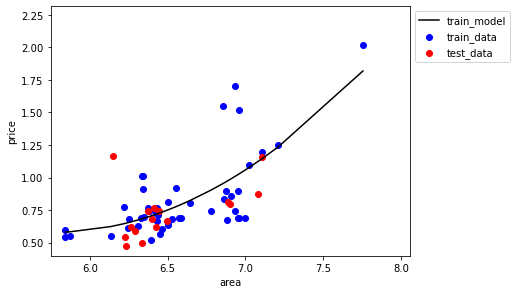

In [53]:
# Plot model:
plt.figure(figsize=(7, 4))
plt.scatter(X_train, Y_train, marker='o', color='blue', label='train_data')
plt.scatter(X_test, Y_test, marker='o', color='red', label='test_data')
# plt.scatter(X_validate, Y_validate, marker='o', color='green', label='validate_data')
plt.plot(X_train, Y_train_ridge_pred, color='black', label='train_model')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.tight_layout()
plt.xlabel('area')
plt.ylabel('price')
plt.xlim(right=max_area+0.3)
plt.ylim(top=max_price+0.3)
plt.show()

## Lasso Regression Model

In [54]:
selected_lasso_alpha = alphas[0]
warnings.filterwarnings('ignore')

lasso_model = linear_model.Lasso(alpha=selected_lasso_alpha, fit_intercept=True, normalize=False, max_iter=2000, tol=0.001)
max_lasso_cv_score = calcCV(lasso_model, selected_X_train_poly, Y_train, 'r2')

for alpha in alphas[1:]:
    lasso_model = linear_model.Lasso(alpha=alpha, fit_intercept=True, normalize=False, max_iter=2000, tol=0.001)
    lasso_cv_score = calcCV(lasso_model, selected_X_train_poly, Y_train, 'r2')
#     neg_root_mean_squared_error

    if lasso_cv_score > max_lasso_cv_score:
        max_lasso_cv_score = lasso_cv_score
        selected_lasso_alpha = alpha
        
# Fit model with selected alpha:
lasso_model = lassoRegressionModel(selected_X_train_poly, Y_train, selected_lasso_alpha)

# Lasso max CV score:
print("Lasso max CV score: ", max_lasso_cv_score)

# RMSE:
lasso_train_rmse = calcRMSE(lasso_model, selected_X_train_poly, Y_train)

print("Lasso Model with alpha = {}".format(selected_lasso_alpha))
print("Lasso Model train RMSE: ", lasso_train_rmse)
print("Lasso Regression coefficient:")
print(lasso_model.coef_)
print("Lasso Regression intercept: ", lasso_model.intercept_)

# Predict Y with Ridge:
Y_train_lasso_pred = lasso_model.predict(selected_X_train_poly)

Lasso max CV score:  -0.608741322005905
Lasso Model with alpha = 0.0005
Lasso Model train RMSE:  0.21531706794597294
Lasso Regression coefficient:
[ 0.         -2.82275515  0.25411556]
Lasso Regression intercept:  [8.36869251]


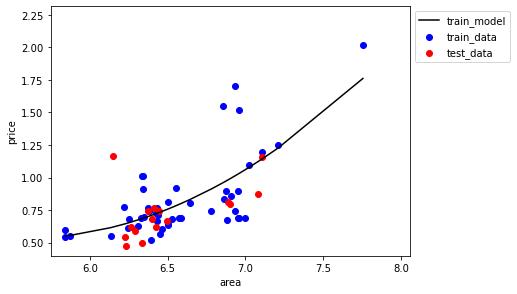

In [55]:
# Plot model:
plt.figure(figsize=(7, 4))
plt.scatter(X_train, Y_train, marker='o', color='blue', label='train_data')
plt.scatter(X_test, Y_test, marker='o', color='red', label='test_data')
# plt.scatter(X_validate, Y_validate, marker='o', color='green', label='validate_data')
plt.plot(X_train, Y_train_lasso_pred, color='black', label='train_model')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.tight_layout()
plt.xlabel('area')
plt.ylabel('price')
plt.xlim(right=max_area+0.3)
plt.ylim(top=max_price+0.3)
plt.show()

In [56]:
# score the model with test data:
X_test_poly = polynomialTransform(X_test, selected_degree)

# Linear score:
print("\n")

linear_train_r2_score = linear_regression_model.score(X_train, Y_train)
print("Linear Model score on train dataset: ", linear_train_r2_score)

linear_test_r2_score = linear_regression_model.score(X_test, Y_test)
print("Linear Model score on test dataset: ", linear_test_r2_score)

# Poly score:
print("\n")

poly_train_r2_score = selected_poly_model.score(selected_X_train_poly, Y_train)
print("Poly Model score on train dataset: ", poly_train_r2_score)

poly_test_r2_score = selected_poly_model.score(X_test_poly, Y_test)
print("Poly Model score on test dataset: ", poly_test_r2_score)

# Ridge score:
print("\n")

ridge_train_r2_score = ridge_model.score(selected_X_train_poly, Y_train)
print("Ridge Model score on train dataset: ", ridge_train_r2_score)

ridge_test_r2_score = ridge_model.score(X_test_poly, Y_test)
print("Ridge Model score on test dataset: ", ridge_test_r2_score)

# Lasso score:
print("\n")

lasso_train_r2_score = lasso_model.score(selected_X_train_poly, Y_train)
print("Lasso Model score on train dataset: ", lasso_train_r2_score)

lasso_test_r2_score = lasso_model.score(X_test_poly, Y_test)
print("Lasso Model score on test dataset: ", lasso_test_r2_score)



Linear Model score on train dataset:  0.4454016274804733
Linear Model score on test dataset:  0.04569049380062129


Poly Model score on train dataset:  0.5299546601155836
Poly Model score on test dataset:  0.1876620995142464


Ridge Model score on train dataset:  0.5243844543422714
Ridge Model score on test dataset:  0.1534937542533903


Lasso Model score on train dataset:  0.5170267586462056
Lasso Model score on test dataset:  0.1345052439123796


In [57]:
models_cv_score = {
    "Linear Regression": linear_cv_score,
    "Polynomial Regression": poly_cv_score,
    "Ridge Regression": max_ridge_cv_score,
    "Lasso Regression": max_lasso_cv_score
}
models_cv_score

{'Linear Regression': -1.5858672103925835,
 'Polynomial Regression': -2.0151733925619246,
 'Ridge Regression': -0.5928743575424238,
 'Lasso Regression': -0.608741322005905}

In [58]:
max_cv_score = max(models_cv_score.values())
best_model_name = [key for key in models_cv_score if models_cv_score[key] == max_cv_score]
print("Best model is ", best_model_name)

Best model is  ['Ridge Regression']


In [59]:
# # calc cross validation score of linear to compare with poly for best model selection
# linear_cv = np.mean(cross_val_score(linear_model, X, Y, cv=5))
# poly_cv = np.mean(cross_val_score(poly_model, X, Y, cv=5))

# best_r2_score = linear_test_r2_score if linear_test_r2_score > poly_test_r2_score else poly_test_r2_score
# best_model = linear_model if linear_cv > poly_cv else poly_model
# best_degree = 1 if linear_cv > poly_cv else degree

# print(linear_cv)
# print(poly_cv)

In [60]:
# import unidecode
# post_type = unidecode.unidecode(post_type.lower().replace(" ", ""))
# street = unidecode.unidecode(street.lower().replace(" ", ""))
# ward = unidecode.unidecode(ward.lower().replace(" ", ""))
# district = unidecode.unidecode(district.lower().replace(" ", ""))
# model_name = post_type + "_" + street + "_" + ward + "_" + district

In [61]:
# model_name

In [62]:
# # Save model after training for later use:
# from joblib import dump, load

# if best_r2_score > 0.7:
#     # Save model:
#     dump((best_model, best_degree), 'trained\\' + model_name + '.joblib')

In [63]:
# try:    
#     # load model:
#     loaded_model, loaded_degree = load('trained/' + model_name + ".joblib")

#     test_area = np.array([92.00])
#     test_area = test_area[:, np.newaxis]
#     test_area = FunctionTransformer(np.log1p).fit_transform(test_area)

#     if loaded_degree == 1:
#         predicted_price = loaded_model.predict(test_area)
#     else:
#         test_area_poly = PolynomialFeatures(degree=loaded_degree).fit_transform(test_area)
#         predicted_price = loaded_model.predict(test_area_poly)

#     print(FunctionTransformer(np.log1p).inverse_transform(predicted_price))
# except FileNotFoundError:
#     print("Model not found or trained result is low!")